Columns in CSV: ['spec_entropy_APPG', 'att_entropy_APPG', 'disp_entropy_APPG', 'slope_entropy_APPG', 'spec_entropy_JPPG', 'att_entropy_JPPG', 'disp_entropy_JPPG', 'slope_entropy_JPPG', 'label']
Original data shape: (219, 8) (219,)
After SMOTE, shape: (258, 8) [199  59]
Class Weights: {0: 0.6482412060301508, 1: 2.1864406779661016}
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_142 (Dense)           (None, 64)                576       
                                                                 
 dropout_113 (Dropout)       (None, 64)                0         
                                                                 
 dense_143 (Dense)           (None, 64)                4160      
                                                        

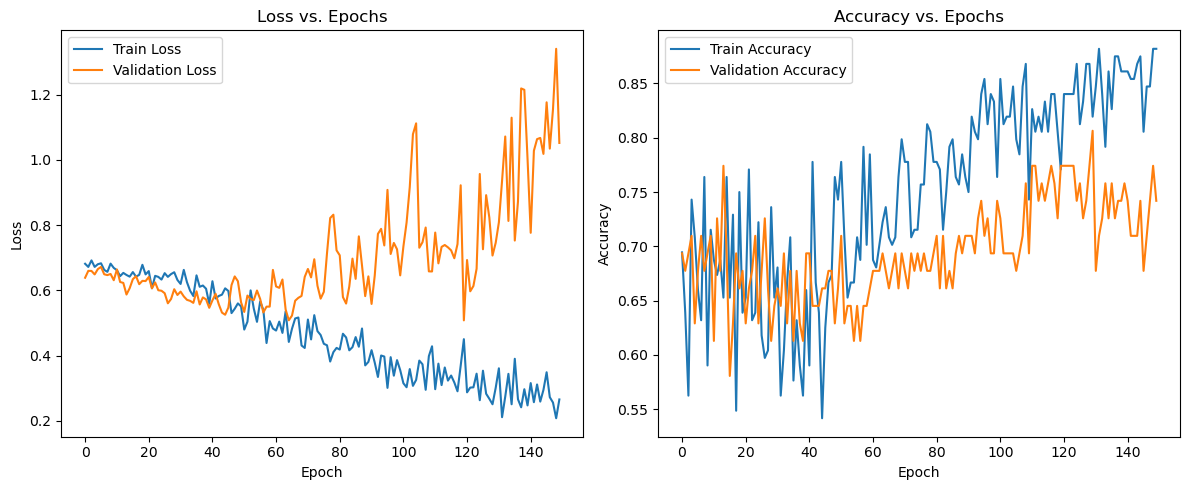

2/2 [==============================] - 0s 3ms/step


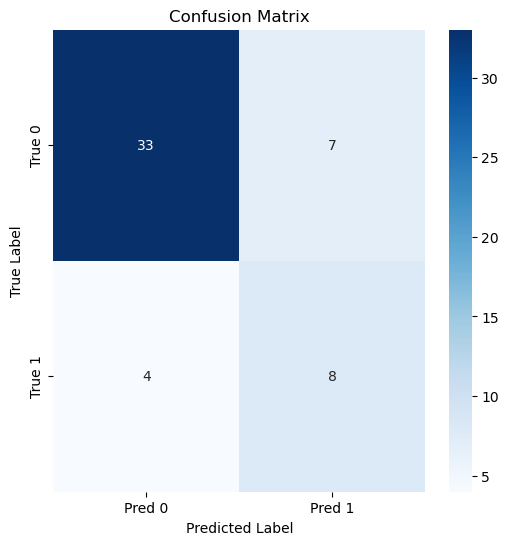

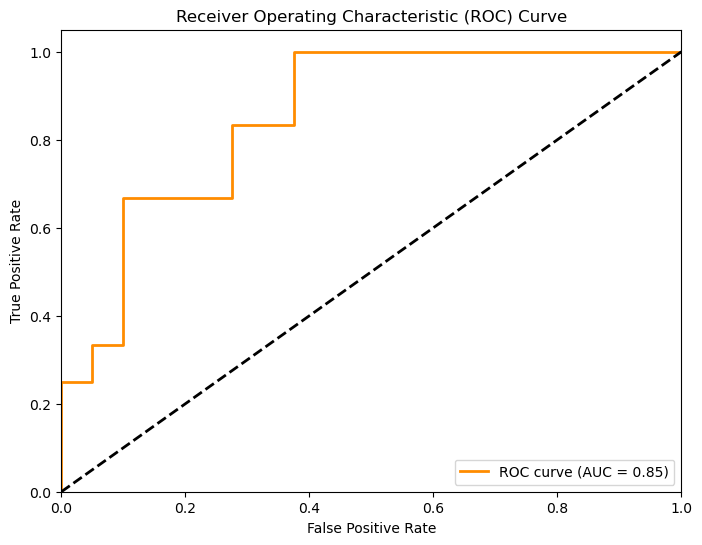

2/2 [==============================] - 0s 4ms/step


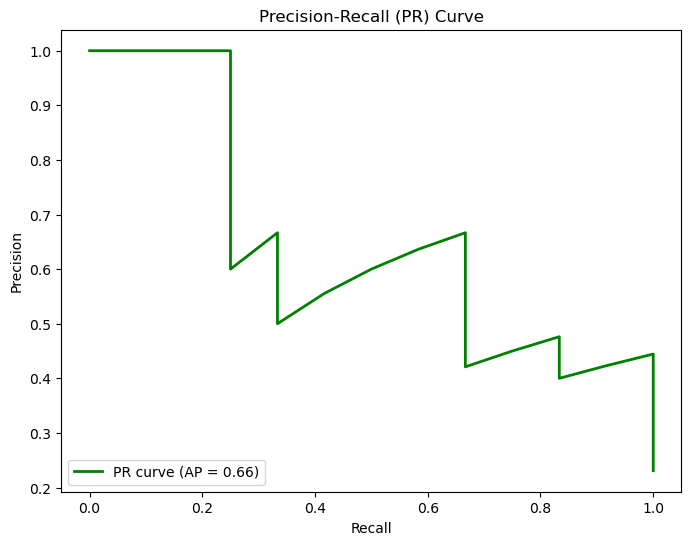

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.86        40
           1       0.53      0.67      0.59        12

    accuracy                           0.79        52
   macro avg       0.71      0.75      0.72        52
weighted avg       0.81      0.79      0.80        52



In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ------------------------------
# 1. Read CSV and Prepare Data
# ------------------------------
data = pd.read_csv('feat_lab.csv')

# Remove extra spaces from column names
data.columns = data.columns.str.strip()
print("Columns in CSV:", data.columns.tolist())

# Extract the 8 entropy feature columns and the label column
feature_cols = ['spec_entropy_APPG', 'att_entropy_APPG', 'disp_entropy_APPG', 
                'slope_entropy_APPG', 'spec_entropy_JPPG', 'att_entropy_JPPG', 
                'disp_entropy_JPPG', 'slope_entropy_JPPG']
X = data[feature_cols].values
y = data['label'].values
print("Original data shape:", X.shape, y.shape)

# ------------------------------
# 2. Feature Scaling (Normalization)
# ------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ------------------------------
# 3. Apply SMOTE with Moderate Sampling Strategy
# ------------------------------
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("After SMOTE, shape:", X_resampled.shape, np.bincount(y_resampled))

# ------------------------------
# 4. Compute Class Weights from Oversampled Data
# ------------------------------
classes = np.unique(y_resampled)
class_weights = compute_class_weight('balanced', classes=classes, y=y_resampled)
class_weights_dict = {int(cls): weight for cls, weight in zip(classes, class_weights)}
print("Class Weights:", class_weights_dict)

# ------------------------------
# 5. Split Data into Train and Test Sets
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ------------------------------
# 6. Define a Custom Fuzzy Layer
# ------------------------------
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Compute per-sample mean and standard deviation
        mean_val = tf.reduce_mean(inputs, axis=1, keepdims=True)
        std_val = tf.math.reduce_std(inputs, axis=1, keepdims=True) + 1e-6
        
        # Triangular Membership Function (approximation)
        tri = tf.maximum(
            tf.minimum((inputs - (mean_val - std_val)) / std_val,
                       ((mean_val + std_val) - inputs) / std_val),
            0.0
        )
        
        # Gaussian Membership Function
        gau = tf.exp(-0.5 * tf.square((inputs - mean_val) / std_val))
        
        # Trapezoidal Membership Function (approximation)
        m = mean_val - std_val
        n = mean_val - 0.5 * std_val
        p = mean_val + 0.5 * std_val
        q = mean_val + std_val
        trap = tf.where(inputs < m, 0.0,
                        tf.where(inputs < n, (inputs - m) / (n - m + 1e-6),
                                 tf.where(inputs <= p, 1.0,
                                          tf.where(inputs < q, (q - inputs) / (q - p + 1e-6), 0.0))))
        
        # Average the membership functions to get the fuzzy output
        fuzzy_output = (tri + gau + trap) / 3.0
        return fuzzy_output

    def compute_output_shape(self, input_shape):
        return input_shape

# ------------------------------
# 7. Build the Improved Model Architecture with Extra Layers
# ------------------------------
def build_model(input_dim=8):
    inputs = Input(shape=(input_dim,))
    
    # Dense Block 1
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Dense Block 2
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Custom Fuzzy Layer inserted here
    x = FuzzyLayer()(x)
    
    # Dense Block 3 (Post-Fuzzy Transformation)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_model(input_dim=8)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------------------
# 8. Train the Model
# ------------------------------
history = model.fit(
    X_train, y_train,
    epochs=150,                # Adjust epochs as needed
    batch_size=2,
    validation_split=0.3,
    class_weight=class_weights_dict
)

# ------------------------------
# 9. Evaluate the Model on the Test Set
# ------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# ------------------------------
# 10. Plot Training Metrics
# ------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# 11. Plot Confusion Matrix
# ------------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ------------------------------
# 12. Plot ROC Curve
# ------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# ------------------------------
# 13. Plot Precision-Recall (PR) Curve and Print Classification Report
# ------------------------------
y_pred_prob = model.predict(X_test)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})', color='green', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (PR) Curve")
plt.legend(loc="lower left")
plt.show()

# Print classification report
y_pred_class = (y_pred_prob > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred_class))


2/2 [==============================] - 3s 15ms/step
Classification Report:
              precision    recall  f1-score   support

        True       0.91      1.00      0.95        30
       False       0.00      0.00      0.00         3

    accuracy                           0.91        33
   macro avg       0.45      0.50      0.48        33
weighted avg       0.83      0.91      0.87        33



c:\Users\anshu\miniconda3\envs\dgfn_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anshu\miniconda3\envs\dgfn_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anshu\miniconda3\envs\dgfn_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


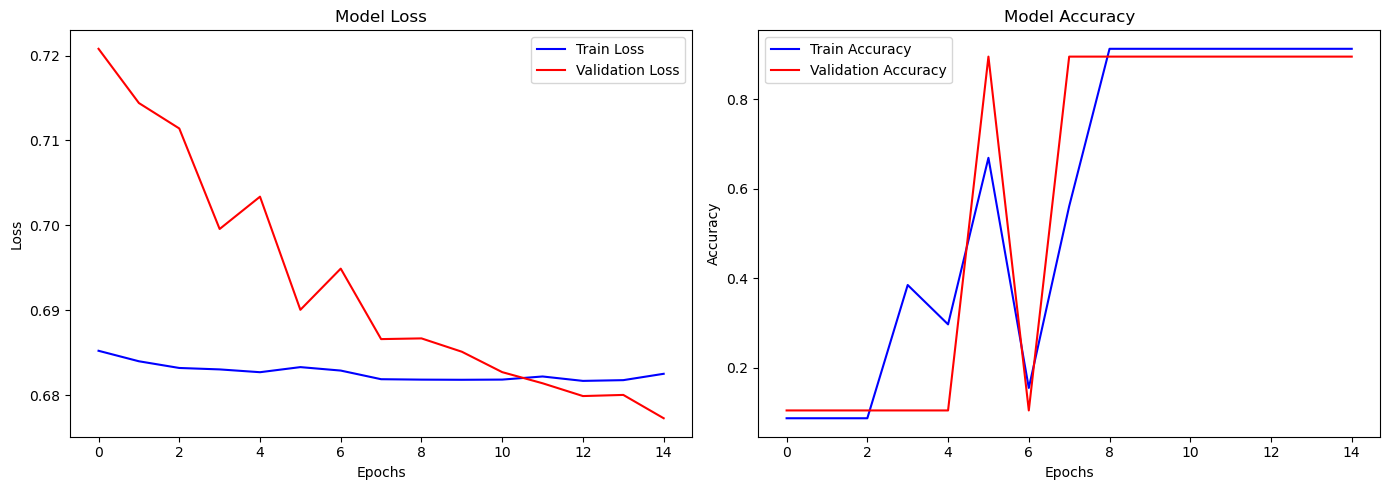

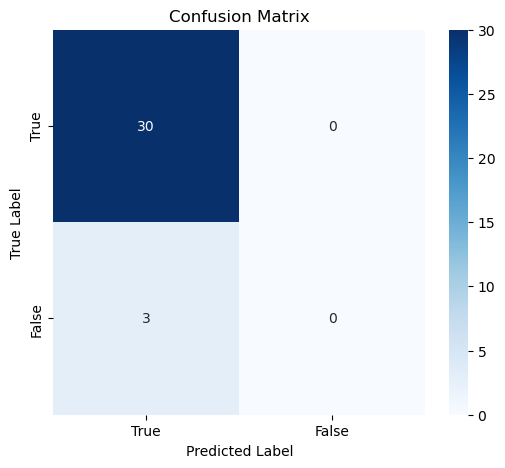

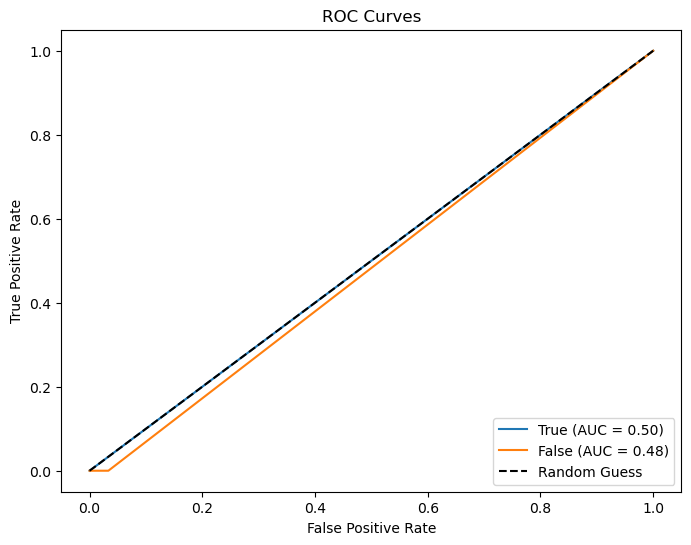

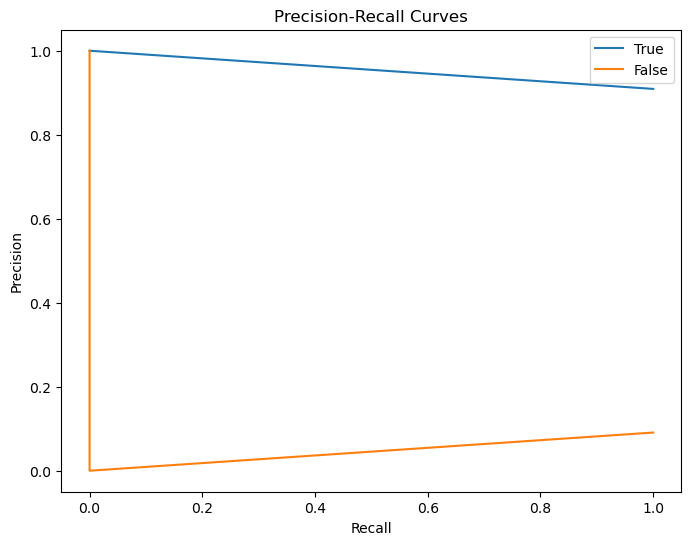

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve)

# Function to plot training history (Loss & Accuracy)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Loss
    ax1.plot(history.history['loss'], label='Train Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot Accuracy (check for key name 'accuracy' or 'acc')
    if 'accuracy' in history.history:
        ax2.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    elif 'acc' in history.history:
        ax2.plot(history.history['acc'], label='Train Accuracy', color='blue')
        ax2.plot(history.history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Function to plot ROC Curves for multi-class classification
def plot_multiclass_roc(y_true, y_probs, class_labels):
    n_classes = len(class_labels)
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall Curves for multi-class classification
def plot_precision_recall(y_true, y_probs, class_labels):
    n_classes = len(class_labels)
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f"{class_labels[i]}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend()
    plt.show()

# Main evaluation function that runs all tests
def evaluate_model(model, X_test, y_test, class_labels, history):
    # Predict probabilities and get predicted classes
    y_probs = model.predict(X_test)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))
    
    # Plot Training History
    plot_training_history(history)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, class_labels)
    
    # Plot ROC Curves (using one-hot encoded y_test)
    plot_multiclass_roc(y_test, y_probs, class_labels)
    
    # Plot Precision-Recall Curves
    plot_precision_recall(y_test, y_probs, class_labels)

# Example usage after model training:

class_labels = ["True", "False"]   # Update as per your dataset
evaluate_model(model, X_test, y_test, class_labels, history)


In [5]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("feature_label.csv")

# Display the first few rows of the dataset
print(df.head())


   spec_entropy_APPG     att_entropy_APPG      disp_entropy_APPG      
0              9.628392              3.741846              2.544623  \
1              9.501315              3.494834              0.604107   
2              9.370558              3.740044              0.888095   
3              9.258800              3.590563              0.863607   
4              9.625976              3.568852              2.649528   

   slope_entropy_APPG    spec_entropy_JPPG    att_entropy_JPPG      
0              2.078708             9.637579             3.432571  \
1              2.193570             9.573340             3.472529   
2              1.780170             9.673726             3.586163   
3              1.962714             9.789286             3.415362   
4              2.030470             9.615393             3.495709   

   disp_entropy_JPPG     slope_entropy_JPPG    label  
0              1.819212              2.055287   True  
1              0.951193              2.116750   

In [ ]:
df

In [6]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Change column type to int32 for column: 'label'
    df = df.astype({'label': 'int32'})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,spec_entropy_APPG,att_entropy_APPG,disp_entropy_APPG,slope_entropy_APPG,spec_entropy_JPPG,att_entropy_JPPG,disp_entropy_JPPG,slope_entropy_JPPG,label
0,9.628392,3.741846,2.544623,2.078708,9.637579,3.432571,1.819212,2.055287,1
1,9.501315,3.494834,0.604107,2.193570,9.573340,3.472529,0.951193,2.116750,1
2,9.370558,3.740044,0.888095,1.780170,9.673726,3.586163,1.920355,1.805022,1
3,9.258800,3.590563,0.863607,1.962714,9.789286,3.415362,1.116771,2.022712,0
4,9.625976,3.568852,2.649528,2.030470,9.615393,3.495709,2.469195,1.961296,1


In [7]:
df_clean.to_csv("feat_lab.csv", index=False)
